# 토끼 데이터

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!gdown https://public.roboflow.com/ds/J92H0VpCFp?key=m51y5Y7IU4

Downloading...
From: https://public.roboflow.com/ds/J92H0VpCFp?key=m51y5Y7IU4
To: /content/J92H0VpCFp?key=m51y5Y7IU4
100% 78.0M/78.0M [00:04<00:00, 18.6MB/s]


In [3]:
!unzip J92H0VpCFp?key=m51y5Y7IU4

Archive:  J92H0VpCFp?key=m51y5Y7IU4
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# xml 함수 가져오기
# file path를 지정하면 해당 폴더의 xml을 하나씩 파싱하여 dataframe 형태로 저장

import glob
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [5]:
TRAIN_PATH = '/content/train'
VAL_PATH = '/content/valid'
TEST_PATH = '/content/test'

In [6]:
train_xml = xml_to_csv(TRAIN_PATH)
val_xml = xml_to_csv(VAL_PATH)
test_xml = xml_to_csv(TEST_PATH)

train_xml.shape, val_xml.shape, test_xml.shape

((2070, 8), (21, 8), (11, 8))

In [7]:
train_xml.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Eastern_Cottontail_JPG.rf.478dbf61c8f3f437058f...,416,416,Cottontail-Rabbit,29,12,381,416
1,06-07-rabbits_jpg.rf.062d42a665cc2d9dcf1b78c0c...,416,416,Cottontail-Rabbit,159,131,295,236
2,06-07-rabbits_jpg.rf.062d42a665cc2d9dcf1b78c0c...,416,416,Cottontail-Rabbit,113,195,180,244
3,20101129-wildlife150_jpg.rf.f23aa1a91c0dcf7363...,416,416,Cottontail-Rabbit,153,107,245,238
4,4057415488_57764053c9_b_jpg.rf.5707260efaec13d...,416,416,Cottontail-Rabbit,29,19,376,364


## 시각화

In [8]:
import PIL
# 이미지 읽기

def read_images(path, xml):
  images = xml.iloc[:,0].values
  points = xml.iloc[:, 4:].values


  dataset_images = []
  dataset_bbs = [] # 정보 저장 bounding box

  for file, point in zip(images, points):
    f = os.path.join(path, file)
    image = PIL.Image.open(f)
    arr = np.array(image)

    dataset_images.append(arr)
    dataset_bbs.append(point)

  dataset_images = np.array(dataset_images)
  dataset_bbs = np.array(dataset_bbs)

  return dataset_images, dataset_bbs

In [9]:
import os
train_images, train_bbs = read_images(TRAIN_PATH, train_xml)
val_images, val_bbs = read_images(VAL_PATH, val_xml)
test_images, test_bbs = read_images(TEST_PATH, test_xml)

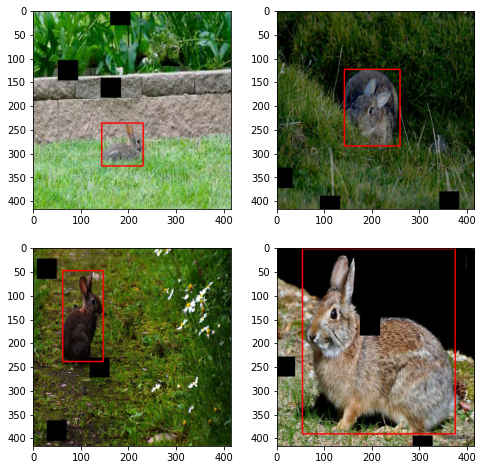

In [10]:
import cv2

samples = np.random.randint(train_images.shape[0], size=4)

plt.figure(figsize=(8,8))
for i, idx in enumerate(samples):
  points = train_bbs[idx].reshape(2,2)

  img = cv2.rectangle(train_images[idx].copy(),
                      tuple(points[0]),
                      tuple(points[1]),
                      color=(255,0,0),
                      thickness=2
                      )
  plt.subplot(2,2,i+1)
  plt.imshow(img)

plt.show()

## 정규화

In [11]:
train_images.shape, train_bbs.shape

((2070, 416, 416, 3), (2070, 4))

In [12]:
X_train = train_images.astype('float32')/255.
y_train = train_bbs.astype('float32')

X_val = val_images.astype('float32')/255.
y_val = val_bbs.astype('float32')

X_test = test_images.astype('float32')/255.
y_test = test_bbs.astype('float32')

## 모델

In [13]:
from tensorflow.keras.applications import MobileNetV2

base = MobileNetV2(input_shape = (416, 416, 3),
                  include_top = False,
                  weights = 'imagenet')
base.trainable = False

model = keras.Sequential([
    base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4)
    # 점 4개를 찾을것 (좌표)
])

model.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['mse']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 13, 13, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 216320)            0         
                                                                 
 dense (Dense)               (None, 128)               27689088  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 29,955,588
Trainable params: 27,697,604
Non-trainable params: 2,257,984
____________________________________

In [14]:
# callback
ckpt_path = '/content/ckpt/cats_bbs.ckpt'

ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32

log = model.fit(X_train, y_train,
          epochs = EPOCHS,
          batch_size = BATCH_SIZE,
          validation_data = (X_val, y_val),
          callbacks = [ckpt_cb],
          verbose = 1)

Epoch 1/30


In [ ]:
model.load_weights(ckpt_path)

## 평가

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.plot(hist['epoch'], hist['mse'], label="Train MSE")
  plt.plot(hist['epoch'], hist['val_mse'], label="Val MSE")
  plt.legend()
  plt.show()

plot_history(log)

In [ ]:
y_pred = model.predict(X_test).astype(int)
y_pred[:3]

In [ ]:
samples = np.random.randint(test_images.shape[0], size=4)

plt.figure(figsize=(8,8))
for i, idx in enumerate(samples):
  points = y_pred[idx].reshape(2,2)

  img = cv2.rectangle(test_images[idx].copy(),
                      tuple(points[0]),
                      tuple(points[1]),
                      color=(255,0,0),
                      thickness=2
                      )
  plt.subplot(2,2,i+1)
  plt.imshow(img)

plt.show()